In [1]:

import numpy as np
from statsmodels.tsa.arima_process import ArmaProcess

from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
import statsmodels.api  as sm


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from datetime import datetime  # for time formating
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
## develop the arma data
np.random.seed(42)

ar1 = np.array([1, -0.33])
ma1 = np.array([1, 0.9])

ARMA_1_1 = ArmaProcess(ar1, ma1).generate_sample(nsample=1000)



In [3]:
ARMA_1_1.shape

(1000,)

In [4]:
## check the stationnary
adf = adfuller(ARMA_1_1)
adf_stats = adf[0]
adf_p = adf[1]

print(adf_stats, adf_p)

# palvue is less than  0.05 stationary

-6.429878682042683 1.7078466680097572e-08


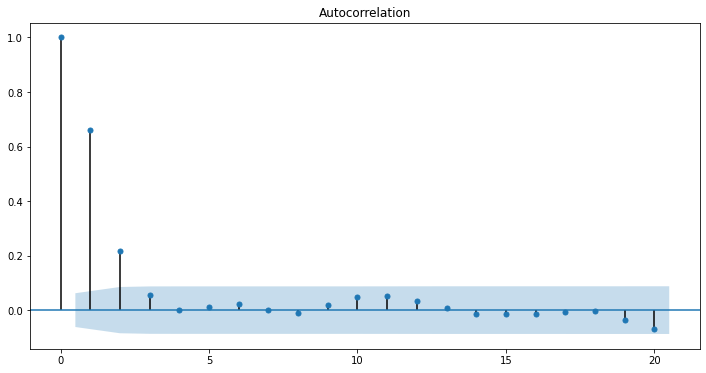

In [5]:
## acf plot for order of  AR
plt.rc("figure", figsize=(12,6))

plot_acf(ARMA_1_1, lags = 20)
plt.show()

# order will be  2  but we take data of AR order 1

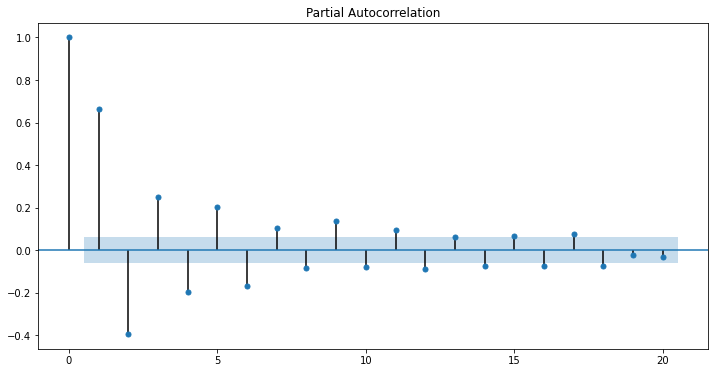

In [6]:
## pacf for order of AR
plot_pacf(ARMA_1_1, lags = 20)
plt.show()

# not able to identify the order of AR

For finding correct order(p,q) for ARMA model we will not use ACF and PACF plot insted we use to select a model based entirely on statistical tests and numerical criteria, instead of relying on the qualitative analysis of the
ACF and PACF plots  

1) we use AIC(Akaike information criterion) which quantifies the quality of each
model in relation to each other. The model with the lowest AIC is then selected  
2) Then we  analyze the model’s residuals, which is the difference between
the actual and predicted values of the model. normally we want residual should be random and does have any pattern

**AIC**: The AIC estimates the quality of a model relative to other models. Given that there
will be some information lost when a model is fitted to the data, the AIC quantifies the
relative amount of information lost by the model. The less information lost, the lower
the AIC value and the better the model.

In [7]:
from itertools import product

ps = range(0, 4, 1)   # 1 is the steps
qs = range(0, 4, 1)

order_list = list(product(ps, qs))  # it give unique combination of ps and qs
print(order_list)

print('Number of combination: {}'.format(len(order_list)))

[(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3), (3, 0), (3, 1), (3, 2), (3, 3)]
Number of combination: 16


In [8]:
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [9]:
# we will take all 16 combiantion of p,q try to fit on data and calculate  AIC score, we will select that which have lowest AICC


from matplotlib.path import simple_linear_interpolation

def optimize_arma(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:  
  results = []
  
  for order in tqdm_notebook(order_list):   # Iterate over each unique (p,q) combination. The use of tqdm_notebook will display a progress bar.

    try:  # is there is no error run try block
      model = SARIMAX(endog, order = (order[0], 0, order[1]), simple_differencing = False).fit(disp = False)   # ARMA model is fit on SARIMAx, diff is false as series is already sation
    except:    # if error occur run except block
        continue

    aic = model.aic
    results.append([order, aic])

  results_df = pd.DataFrame(results)
  results_df.columns = ['(p,q)', 'AIC']


  # sort in AIC ascending order
  results_df = results_df.sort_values(by = 'AIC', ascending = True).reset_index(drop = True)

  return results_df



In [10]:
optimize_arma(ARMA_1_1, order_list)

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(1, 1)",2801.407785
1,"(2, 1)",2802.906070
2,"(1, 2)",2802.967762
3,"(0, 3)",2803.666793
4,"(1, 3)",2804.524027
5,"(3, 1)",2804.588567
6,"(2, 2)",2804.822282
7,"(3, 3)",2806.163145
8,"(2, 3)",2806.175380
9,"(3, 2)",2806.894930


**Inference:** AIC measure how much information is lost by fitting model in data and low AIc score means less info is lost.  

  
lowest AIC is of order(1,1) same as data so we can say that this is correct way to find the order 

**Residual Analysis** :   
AIC is a measure of relative quality but we also need  we need an absolute measure of the model’s quality  

Residual analysis is simple: observed series - predicted equation series  
In this we want some  properties should we satisifed:  
1) residual(error) is normally distributed as a white noise  
2) error should be uncorrelated  

  
1) To check normal  condition we  can we QQ plot or any test  
2) for no auto correlation we use Ljung-Box test

In [11]:
## define the model
model = SARIMAX(ARMA_1_1, order = (1,0,1), simple_differencing= False).fit(disp = False)
residuals = model.resid
print(residuals)


[ 4.96714153e-01  1.47721307e-01  4.43731915e-01  1.80363131e+00
 -2.09827141e-01 -2.37428222e-01  1.57044235e+00  8.76423378e-01
 -4.86274295e-01  5.68300730e-01 -4.68710767e-01 -4.61285811e-01
  2.20202855e-01 -1.90267860e+00 -1.76321476e+00 -5.95922478e-01
 -1.04526883e+00  3.02326062e-01 -9.30064196e-01 -1.40173568e+00
  1.42552961e+00 -2.24884042e-01  8.76246391e-02 -1.44130465e+00
 -5.30184414e-01  6.31165978e-02 -1.13128268e+00  3.50988732e-01
 -6.07279073e-01 -2.86630995e-01 -6.21258307e-01  1.85816372e+00
 -3.72358482e-02 -9.97107113e-01  7.79382718e-01 -1.20281184e+00
  2.05425161e-01 -1.98192211e+00 -1.31028986e+00  1.32367869e-01
  7.49507774e-01  1.49713621e-01 -8.15904236e-02 -3.23539304e-01
 -1.45759493e+00 -7.45529660e-01 -4.74808831e-01  1.04037683e+00
  3.37318625e-01 -1.73879105e+00  3.17328019e-01 -4.17005812e-01
 -6.51970351e-01  5.78264770e-01  1.04137391e+00  9.29305424e-01
 -8.10294401e-01 -3.03590751e-01  3.16414720e-01  9.78248381e-01
 -4.77808651e-01 -1.61490

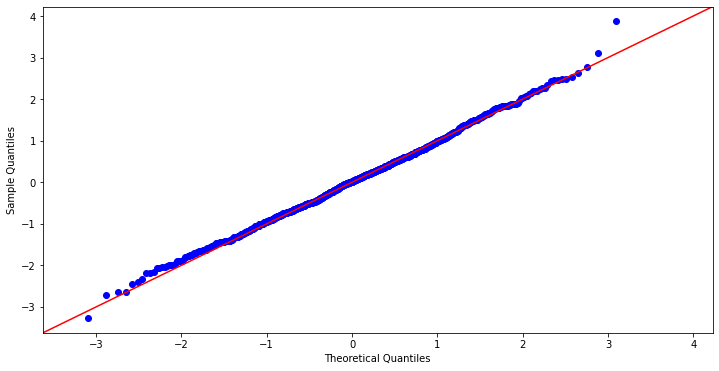

In [12]:
## QQ Plot
from statsmodels.graphics.gofplots import qqplot
qqplot(residuals, line = '45')
plt.show()

**Inference**: As most of point lie on line therefore we can say that residual is normally distributed.  


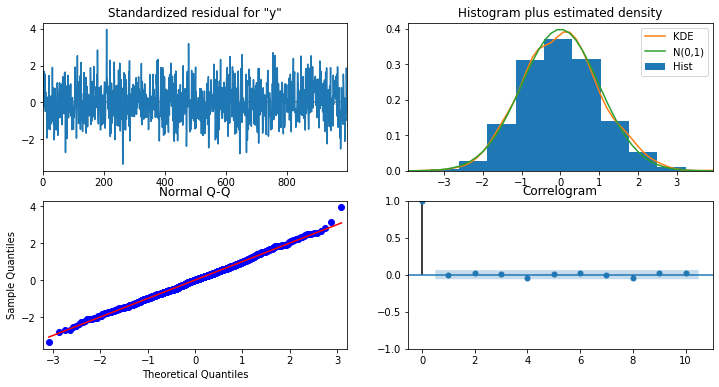

In [13]:
## diagnostics plot  
model.plot_diagnostics(figsize = (12,6))
plt.show()

1) first plot is residual over the sereies, we cannot see any pattern or trend so we conclude that model is fitted very well and also  indicative of stationarity, just like white noise.  
  
2) histogram of residual which show  the normally distribured  

3) QQ Plot also show  of normally distributed  

4) auto correlation between the error and it show that there is correlation

### Ljung-Box Test:  
The Ljung-Box test is a statistical test that determines whether the autocorrelation of a group of data is significantly different from 0.

H0: no auto correlation, 0  
H1: There is auto correlaion in  a group  

Output: statistic and p-value

In [14]:
from statsmodels.stats.diagnostic import acorr_ljungbox

lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))  # cosnidering 10 lag

print(pvalue)  

# for all lag p-vaue is >0.05 there H0 is true and there is no autocorrealtion for any lag and  residuals are completely random

[0.86089685 0.76796558 0.90981746 0.72108901 0.81038546 0.82174996
 0.89406254 0.81750093 0.85241945 0.87409314]


## Apply ARMA on climate dataset

In [15]:
df = pd.read_csv('https://raw.githubusercontent.com/surendra769/Time-Series-Econometrics-and-Finance/main/DailyDelhiClimateTest.csv')
df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333


In [16]:
df = df[['date', 'meantemp']]
df.head()

,date,meantemp
0,2017-01-01,15.913043
1,2017-01-02,18.500000
2,2017-01-03,17.111111
3,2017-01-04,18.700000
4,2017-01-05,18.388889


In [17]:
df['date'] = pd.to_datetime(df['date'])


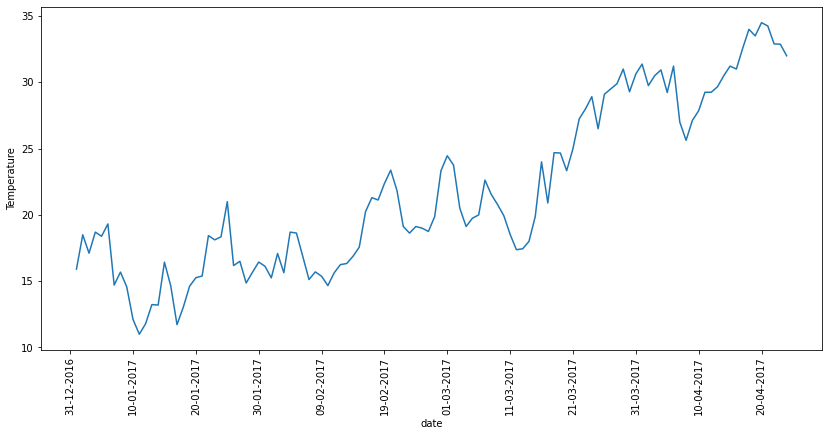

In [18]:
plt.figure(figsize = (14,7))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))     #specify the date foramt of  xaxis

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))  # specify  the interval
plt.gcf().autofmt_xdate()    # manage the space

sns.lineplot(df['date'], df['meantemp'])
plt.ylabel('Temperature')

plt.xticks(rotation=90)     # rotate the xaxis value by 90 degree
plt.show()

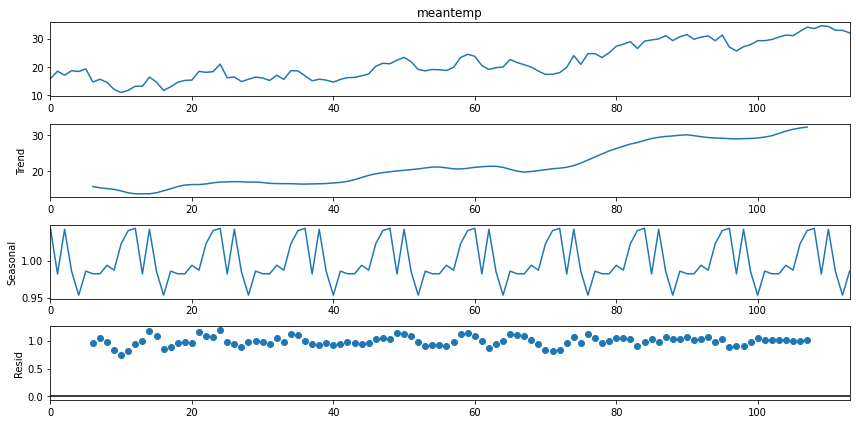

In [19]:
## to get  the better idea about trend, cyclical variation and  residuall
decomposition = sm.tsa.seasonal_decompose(df['meantemp'],period = 12, model = 'multiplicative' )
decomposition.plot()
plt.show()     # to get only one plot 

In [20]:
ADF_result = adfuller(df['meantemp'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')


ADF Statistic: -1.096474275875619
p-value: 0.7164758731775932


In [21]:
## remove the trend by differcing  
df['diff_temp'] = np.diff(df['meantemp'], n = 1,prepend = df['meantemp'][1])    # without prepend we get one value less as it value start from 2nd value -1 value of column

# again adf test
adf_test = adfuller(df['diff_temp'])


print('{} is a statistic value'.format(adf_test[0]))
print('{} is a p value'.format(adf_test[1]))
## as p value is less than 0.05 therefore we reject the null  hypothesis

-12.334379916007231 is a statistic value
6.32139424982012e-23 is a p value


In [22]:
## we will take 80-20 train test 

train = df.iloc[:int(df.shape[0]*0.80),]    # earlier train, test dont have diff variable  train, test
test = df.iloc[int(df.shape[0]*0.80):,]

In [23]:
print('Train size', train.shape)
print('Test size', test.shape)

Train size (91, 3)
Test size (23, 3)


In [24]:
result_arma = optimize_arma(train['diff_temp'], order_list)  # we have order ist of  upto (3,3)
result_arma

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(0, 0)",364.090723
1,"(1, 0)",364.374980
2,"(0, 1)",364.441224
3,"(1, 1)",366.342943
4,"(2, 0)",366.348933
5,"(0, 2)",366.387467
6,"(3, 2)",366.926843
7,"(2, 3)",367.095846
8,"(0, 3)",368.032728
9,"(3, 0)",368.281445


In [25]:
model = SARIMAX(train['diff_temp'], order=(1,0,0), simple_differencing=False)
model_fit = model.fit(disp=False)
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:              diff_temp   No. Observations:                   91
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -180.187
Date:                Sat, 24 Dec 2022   AIC                            364.375
Time:                        13:57:04   BIC                            369.397
Sample:                             0   HQIC                           366.401
                                 - 91                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1377      0.106     -1.297      0.195      -0.346       0.070
sigma2         3.0712      0.456      6.730      0.000       2.177       3.966
Ljung-Box (L1) (Q):                   0.00   Jarque-

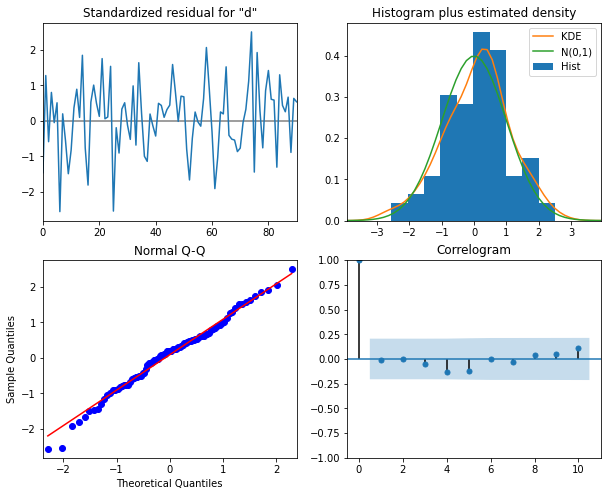

In [26]:
model_fit.plot_diagnostics(figsize=(10, 8));


In [27]:
## correlation test
residuals = model_fit.resid

lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(pvalue)  

# all are uncorrealted

[0.95530719 0.99816074 0.96883816 0.75654039 0.65582069 0.77180803
 0.84980531 0.89801121 0.92585626 0.88979542]


#### Forecasting and calculating model accuracy

In [28]:
arma = pd.DataFrame(model_fit.forecast(23))  # predicted value
arma.columns = ['arma_pred']

In [29]:
test.head()

,date,meantemp,diff_temp
91,2017-04-02,29.750000,-1.625000
92,2017-04-03,30.500000,0.750000
93,2017-04-04,30.933333,0.433333
94,2017-04-05,29.230769,-1.702564
95,2017-04-06,31.222222,1.991453


In [30]:
test = test.join(arma['arma_pred'])  # prediction  is on scale on differcing so we compare to diff_temp

In [31]:
test.head()

,date,meantemp,diff_temp,arma_pred
91,2017-04-02,29.750000,-1.625000,-0.103241
92,2017-04-03,30.500000,0.750000,0.014212
93,2017-04-04,30.933333,0.433333,-0.001956
94,2017-04-05,29.230769,-1.702564,0.000269
95,2017-04-06,31.222222,1.991453,-0.000037


In [32]:
test.head()

,date,meantemp,diff_temp,arma_pred
91,2017-04-02,29.750000,-1.625000,-0.103241
92,2017-04-03,30.500000,0.750000,0.014212
93,2017-04-04,30.933333,0.433333,-0.001956
94,2017-04-05,29.230769,-1.702564,0.000269
95,2017-04-06,31.222222,1.991453,-0.000037


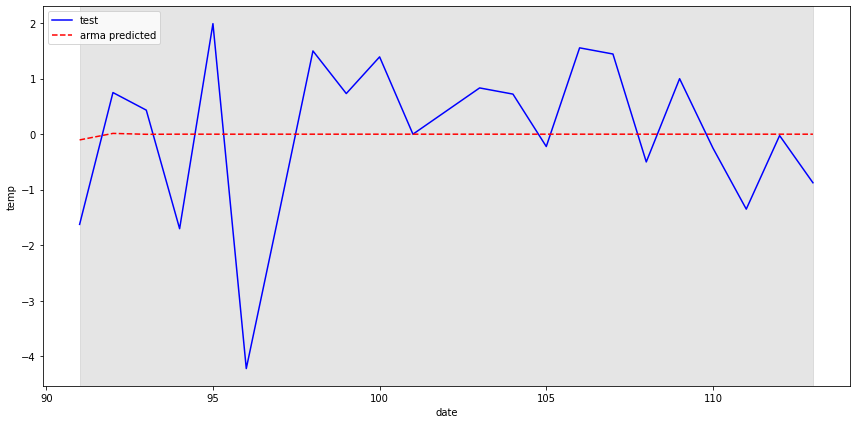

In [33]:
fig, ax = plt.subplots()
#ax.plot(train['meantemp'], 'g-.' , label = 'train')
ax.plot(test['diff_temp'], 'b-', label = 'test')
ax.plot(test['arma_pred'], 'r--',label = 'arma predicted')
ax.axvspan(91, 113, color='#808080', alpha=0.2)   # give different color to predicted area
ax.set_xlabel('date')
ax.set_ylabel('temp')
ax.legend(loc=2)
#fig.automft_xdate()  # fit xtick value automatically
plt.tight_layout()

#### Check the accuracy of model

In [34]:
# function to  calcualte Mean Absolute Percentage Error
def MAPE(Y_actual,Y_Predicted):  
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [35]:
mape = MAPE(test['diff_temp'], test['arma_pred'])   # due to +,- unable to calculate the MAPE
print("MAPE: ", mape) 


MAPE:  inf


In [36]:
from sklearn.metrics import mean_squared_error
MSE = mean_squared_error(test['diff_temp'], test['arma_pred'])
RMSE = np.sqrt(MSE)

print("Root Mean Square Error", RMSE)

Root Mean Square Error 1.386309823691008


### ARIMA   
Applying AR, MA, ARMA model on data after diff then again we need to rescale the predicted value  to plot and cal MAPE and RMSE  

In ARIMA model we also differencing also  

the mathematical expression of the ARIMA(p,d,q) process states that
the present value of the differenced series y't is equal to the sum of a constant C, past values of the differenced series ϕpy't–p, the mean of the differenced series µ, past error terms θqϵt–q, and a current error term ϵt,  
  

An autoregressive integrated moving average (ARIMA) process is the combination of
the AR(p) and MA(q) processes, but in terms of the differenced series.

In [38]:
df = pd.read_csv('https://raw.githubusercontent.com/marcopeix/AppliedTimeSeriesAnalysisWithPython/main/data/jj.csv')
df.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


I can we take  1 for most of the cases but  dtertmine by same procedure as differencing and doing ADF testing and order(p,q) determine by same AIC 

In [39]:
# fuction to find AIC

def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [42]:
df.shape

(84, 2)

In [40]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
d = 2

order_list = list(product(ps, qs))

In [62]:

test

,date,data
74,1978-07-02,12.15
75,1978-10-01,8.91
76,1979-01-01,14.04
77,1979-04-02,12.96
78,1979-07-02,14.85
79,1979-10-01,9.99
80,1980-01-01,16.20
81,1980-04-01,14.67
82,1980-07-02,16.02
83,1980-10-01,11.61


In [61]:
#train = df.iloc['data'][:-10]
test = df.iloc[-10:]



#result_df = optimize_ARIMA(train, order_list, d)
#result_df

In [45]:
model = SARIMAX(train, order=(3,2,2), simple_differencing=False)
model_fit = model.fit(disp=False)

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                   74
Model:               SARIMAX(3, 2, 2)   Log Likelihood                 -18.609
Date:                Sat, 24 Dec 2022   AIC                             49.218
Time:                        15:41:28   BIC                             62.878
Sample:                             0   HQIC                            54.656
                                 - 74                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1101      0.047    -23.785      0.000      -1.202      -1.019
ar.L2         -1.1039      0.036    -30.823      0.000      -1.174      -1.034
ar.L3         -0.9557      0.038    -24.877      0.0

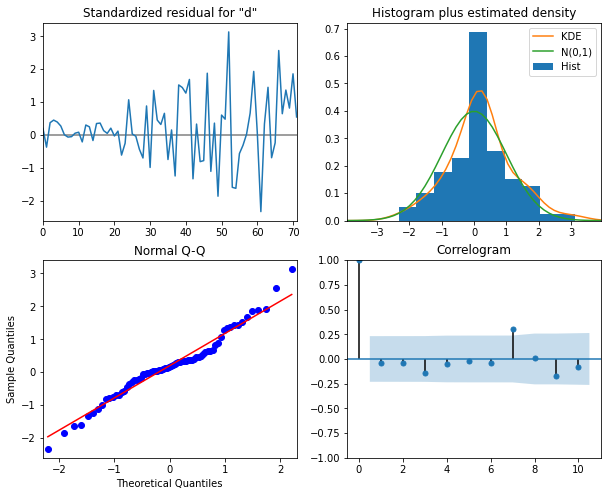

In [46]:
model_fit.plot_diagnostics(figsize=(10,8));
## variaie is constant, but we can ignore

In [47]:
residuals = model_fit.resid

lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(pvalue)  # no correlation

[0.22989924 0.45324887 0.19916174 0.32330019 0.45715197 0.57603185
 0.16642031 0.23688051 0.1992854  0.24498101]


In [63]:
ARIMA_pred = model_fit.get_prediction(74, 83).predicted_mean   # forecast

test['ARIMA_pred'] = ARIMA_pred
test    # here we see the predicted value have same scale of original scale


,date,data,ARIMA_pred
74,1978-07-02,12.15,11.069907
75,1978-10-01,8.91,10.832122
76,1979-01-01,14.04,13.889214
77,1979-04-02,12.96,13.576443
78,1979-07-02,14.85,12.648521
79,1979-10-01,9.99,12.974462
80,1980-01-01,16.20,15.808066
81,1980-04-01,14.67,15.061699
82,1980-07-02,16.02,14.323067
83,1980-10-01,11.61,15.131091


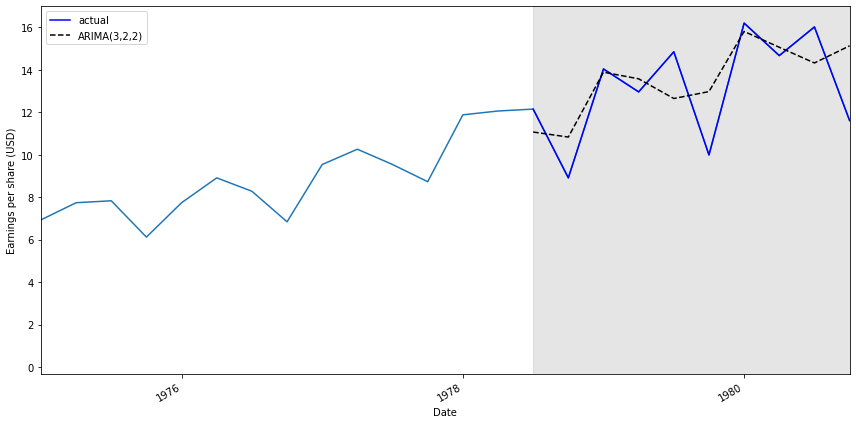

In [68]:
fig, ax = plt.subplots()

ax.plot(df['date'], df['data'])
ax.plot(test['data'], 'b-', label='actual')
#ax.plot(test['naive_seasonal'], 'r:', label='naive seasonal')
ax.plot(test['ARIMA_pred'], 'k--', label='ARIMA(3,2,2)')

ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(74, 83, color='#808080', alpha=0.2)

ax.legend(loc=2)

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])
ax.set_xlim(60, 83)

fig.autofmt_xdate()
plt.tight_layout()

In [70]:
mape = MAPE(test['data'], test['ARIMA_pred'])   # due to +,- unable to calculate the MAPE
mape

12.700213235613504

In [69]:
test

,date,data,ARIMA_pred
74,1978-07-02,12.15,11.069907
75,1978-10-01,8.91,10.832122
76,1979-01-01,14.04,13.889214
77,1979-04-02,12.96,13.576443
78,1979-07-02,14.85,12.648521
79,1979-10-01,9.99,12.974462
80,1980-01-01,16.20,15.808066
81,1980-04-01,14.67,15.061699
82,1980-07-02,16.02,14.323067
83,1980-10-01,11.61,15.131091


In [71]:
MSE = mean_squared_error(test['data'], test['ARIMA_pred'])
RMSE = np.sqrt(MSE)

print("Root Mean Square Error", RMSE)

Root Mean Square Error 1.860164583055727
